In [57]:
import open3d as o3d
import numpy as np
import os
from tqdm import tqdm
#import tensorflow as tf
import random
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd

## Fix your path here

In [2]:
filepath = ["data/female", "data/male"]

In [22]:
#count how many objects there are in total
fem = []
mal = []
for obj in glob.iglob("./data/female/*.obj"):
    fem.append(1)
for obj in glob.iglob("./data/male/*.obj"):
    mal.append(1)

fem_tot, mal_tot, total = len(fem), len(mal), len(fem)+len(mal)

print("There are " + str(fem_tot) + " female objects")
print("There are " + str(mal_tot) + " male objects")
print("In total there are " + str(total) + " number of objects")

There are 1531 female objects
There are 1517 male objects
In total there are 3048 number of objects


In [4]:
# data_paths = filepath

# N = 5

# pcds_females = []
# pcds_males = []
# pcds = [pcds_females, pcds_males]

# for data in range(len(data_paths)):
#     files = []
#     folder_to_view = data_paths[data]

#     list = pcds[data]
#     for file in os.listdir(folder_to_view):
#         files.append(file)
#     for i in tqdm(range(N)):
#         file = (folder_to_view + "/" + str(files[i]))
#         mesh = o3d.io.read_triangle_mesh(file)
#         vertices = np.asarray(mesh.vertices)
#         center = vertices.mean(axis=0)
#         vertices -= center
#         mesh.vertices = o3d.utility.Vector3dVector(vertices)
#         mesh.get_center()
#         pcd = mesh.sample_points_uniformly(2048)
#         #pcd = pcd.voxel_down_sample(voxel_size=0.5)
#         list.append(pcd)

In [5]:
def Load_data(filepath, N): 
    # function takes filepath to data folder, and number of objects we want to load
    pcds_females = []
    pcds_males = []
    pcds = [pcds_males, pcds_females]
    for folder in range(len(filepath)):
        objects = []
        folder_to_view = filepath[folder]
        for object in os.listdir(folder_to_view):
            objects.append(object) #appends all objects to either female or male folder
        for i in tqdm(range(N)):
            file = (folder_to_view + "/" + str(objects[i])) #iterates over each object

            mesh = o3d.io.read_triangle_mesh(file) #load each object as mesh
            #cetralises each mesh object
            vertices = np.asarray(mesh.vertices)
            center = vertices.mean(axis=0)
            vertices -= center
            mesh.vertices = o3d.utility.Vector3dVector(vertices)

            #converts mesh to pcd and downsamples to 2048 points
            pcd = mesh.sample_points_uniformly(2048)

            pcds[folder].append(pcd)

    return pcds_females, pcds_males, pcds

In [6]:
class PointCloudDataset(Dataset):
    def __init__(self):

        males = []
        females =[]

        #load females
        for obj in glob.iglob("./data/female/*.obj"):
            mesh = o3d.io.read_triangle_mesh(obj)

            #cetralises each mesh object
            vertices = np.asarray(mesh.vertices)
            center = vertices.mean(axis=0)
            vertices -= center
            mesh.vertices = o3d.utility.Vector3dVector(vertices)

            #converts mesh to pcd and downsamples to 2048 points
            pcd = mesh.sample_points_uniformly(2048)
            females.append(pcd)
        
        #load males
        for obj in glob.iglob("./data/male/*.obj"):
            mesh = o3d.io.read_triangle_mesh(obj)

            #cetralises each mesh object
            vertices = np.asarray(mesh.vertices)
            center = vertices.mean(axis=0)
            vertices -= center
            mesh.vertices = o3d.utility.Vector3dVector(vertices)

            #converts mesh to pcd and downsamples to 2048 points
            pcd = mesh.sample_points_uniformly(2048)
            males.append(pcd)

        
        
        self.females = females
        self.males = males
        self.pcds = np.concatenate((females, males), axis=0)
    
    def __len__(self):
        return len(self.pcds)
    
    def __getitem__(self, idx):
        return self.pcds[idx]

In [7]:
#Load entire dataset and stash in the pytorch class: (takes approx 2-3 min)
pcds_dataset = PointCloudDataset()

print(len(pcds_dataset))

3048


In [9]:
#access each pointcloud from the loaded dataset
pcds_dataset[200]

PointCloud with 2048 points.

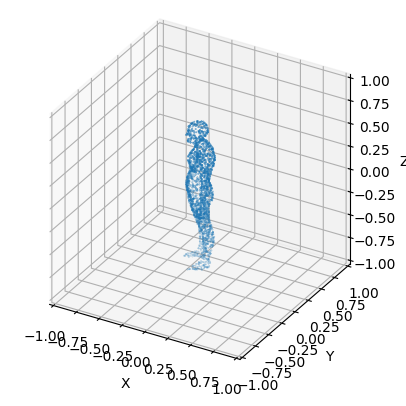

In [16]:
#use function to visualize different pointclouds
visualize(pcds_dataset[200])

### Normals

In [18]:
pcds_females, pcds_males, pcds = Load_data(filepath=filepath, N = 5)

100%|██████████| 5/5 [00:00<00:00, 21.91it/s]


In [125]:
def Get_normals(pcds_females): 
    normals = []
    for i in range(len(pcds_females)):
        normals.append(np.asarray(pcds_females[i].normals))
    return normals
normalerne = Get_normals(pcds_females)

np.shape(normalerne[0])

(2048, 3)

### Convert to numpy array

In [126]:
pcds_females_arr = []
pcds_males_arr = []
pcds_arr = [pcds_females_arr, pcds_males_arr]


for points in range(len(pcds)): 
    for i in tqdm(range(len(pcds_females))):
        pcds_arr[points].append(np.asarray(pcds[points][i].points) )



100%|██████████| 5/5 [00:00<00:00, 51025.60it/s]


In [127]:
furthest_distance = 0

for points in range(len(pcds_arr)): 
    for i in range(len(pcds_males_arr)):
        distance = np.max(np.sqrt(np.sum(abs(pcds_arr[points][i])**2,axis=1)))
        if distance > furthest_distance:
            furthest_distance = distance
            
furthest_distance

0.9907830883265987

### Normalize (Update to normalize in regards to biggest person)

In [128]:
def normalize(points): # The input of this function is a point cloud object
    # This function normalizes a point cloud within a unit sphere
    points = np.asarray(points.points) 
    centroid = np.mean(points, axis=0)
    points -= centroid
    points / furthest_distance
    return points # The function return a numpy array of dimension nx3 where the points are normalized within a unit sphere

pcds_females_arr_norm = []
pcds_males_arr_norm = []
pcds_arr_norm = [pcds_females_arr_norm, pcds_males_arr_norm]


for points in range(len(pcds_arr)):
    for i in tqdm(range(len(pcds_females))):
        pcds_arr_norm[points].append(normalize(pcds[points][i]))

100%|██████████| 5/5 [00:00<00:00, 5223.29it/s]


In [129]:
furthest_distance = 0

for points in range(len(pcds_arr_norm)): 
    for i in range(len(pcds_males_arr)):
        distance = np.max(np.sqrt(np.sum(abs(pcds_arr_norm[points][i])**2,axis=1)))
        if distance > furthest_distance:
            furthest_distance = distance
            
furthest_distance

0.9783446727681298

# Centraliser

In [52]:
def visualize3d(points):
    points = np.asarray(points.points) #takes pointcloud makes it into np.array [x,y,z] koordinates

    #Plot it using matplotlib with tiny points and constrained axes
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0.5, cmap=plt.hot()) #define size of points
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect((1,1,1)) # Constrain the axes
    ax.set_proj_type('ortho') # Use orthographic projection
    ax.set_xlim(-1,1) # Set x-axis range
    ax.set_ylim(-1,1) # Set y-axis range
    ax.set_zlim(-1,1) # Set z-axis range
    plt.show()


#visualize(pcds_females[2])

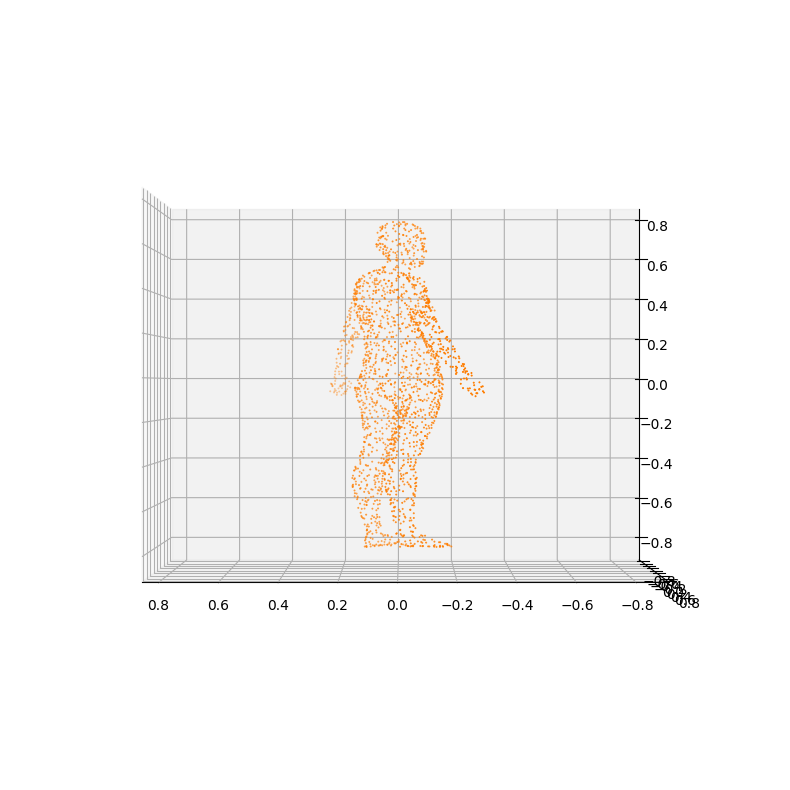

In [60]:
from pyntcloud import PyntCloud
#import pypotree

cloud = np.asarray(pcds_dataset[200].points)
df = pd.DataFrame(cloud, columns = ['x','y','z'])
pointcloud = PyntCloud(df)
pointcloud.plot()


In [55]:
np.asarray(pcds_dataset[200].points)

array([[ 0.22910551, -0.31993722,  0.01840041],
       [ 0.18700598, -0.28043106,  0.07127482],
       [ 0.21546118, -0.24629418,  0.11778637],
       ...,
       [-0.02909224, -0.01209957, -0.10531788],
       [-0.04223195, -0.04182427, -0.09387134],
       [-0.03385922, -0.01773143, -0.10010352]])

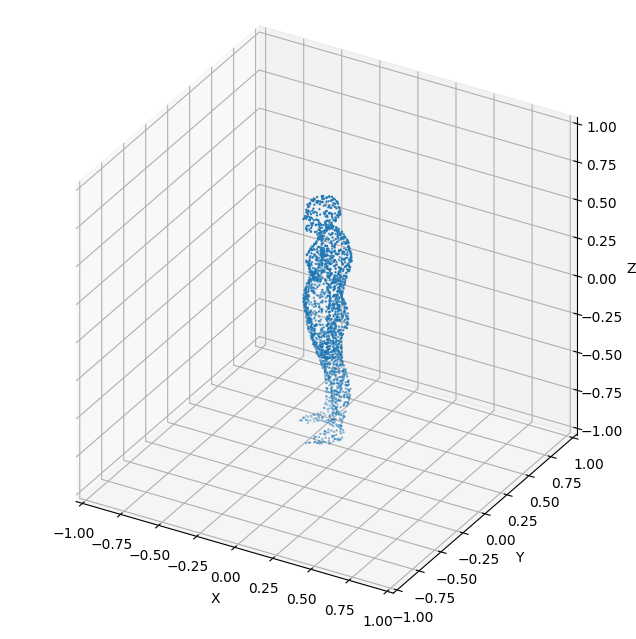

In [53]:
visualize3d(pcds_dataset[200])

# Augmentation

### Rotation

In [131]:
test_person = pcds_females[2]

In [132]:
# Define the maximum angle in degrees for the random rotation
max_angle = 45

mesh = o3d.io.read_triangle_mesh("data/female/SPRING0060.obj")
# Generate a random rotation axis and angle
axis = np.random.uniform(-1, 1, 3)
axis /= np.linalg.norm(axis)
angle = np.random.uniform(-max_angle, max_angle) * np.pi / 180  # convert degrees to radians

# Create the rotation matrix using Open3D's utility function
#rot_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(axis, angle)

R = mesh.get_rotation_matrix_from_xyz((np.pi / 2, np.pi / 2, np.pi / 2))


# Apply the rotation to the point cloud using Open3D's built-in transform function
test_rotate = test_person.rotate(R)

### To visualise point cloud

In [133]:
#o3d.visualization.draw_geometries([test_person,pcds_males[2]])